In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 2000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.10)
params.platforms.discount = float(0.0)

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.8
params.d2d.B_WOM = 0.18
params.d2d.B_Marketing = 0.02
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 400
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [6]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

# sim = MaaSSim.simulators.simulate(params=params,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
21-12-22 09:56:57-WARNING-Setting up 4h simulation at 2022-12-21 07:56:40 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
Day =  0
21-12-22 09:57:04-WARNING-simulation time 2.4 s
Day =  1
21-12-22 09:57:12-WARNING-simulation time 2.6 s
Day =  2
21-12-22 09:57:20-WARNING-simulation time 2.6 s
Day =  3
21-12-22 09:57:28-WARNING-simulation time 2.5 s
Day =  4
21-12-22 09:57:36-WARNING-simulation time 2.8 s
Day =  5
21-12-22 09:57:47-WARNING-simulation time 4.0 s
Day =  6
21-12-22 09:57:58-WARNING-simulation time 3.7 s
Day =  7
21-12-22 09:58:10-WARNING-simulation time 4.0 s
Day =  8
21-12-22 09:58:22-WARNING-simulation time 4.2 s
Day =  9
21-12-22 09:58:33-WARNING-simulation time 4.0 s
Day =  10
21-12-22 09:58:45-WARNING-simulation time 4.1 s
Day =  11
21-12-22 09:58:56-WARNING-simulation time 4.0 s
Day =  12
21-12-22 09:59:08-WARNING-simulation time 4.1 s
Day =  13
21-12-22 09:59:19-WARNING-simulation time 4.3 s
Day =  14
21-12-22 09:59:3

In [37]:
e_u = 0
wom_u = -0.5
m_u = -0.5

(e_u*0.5) + (wom_u*0.3) + (m_u*0.2)

-0.25

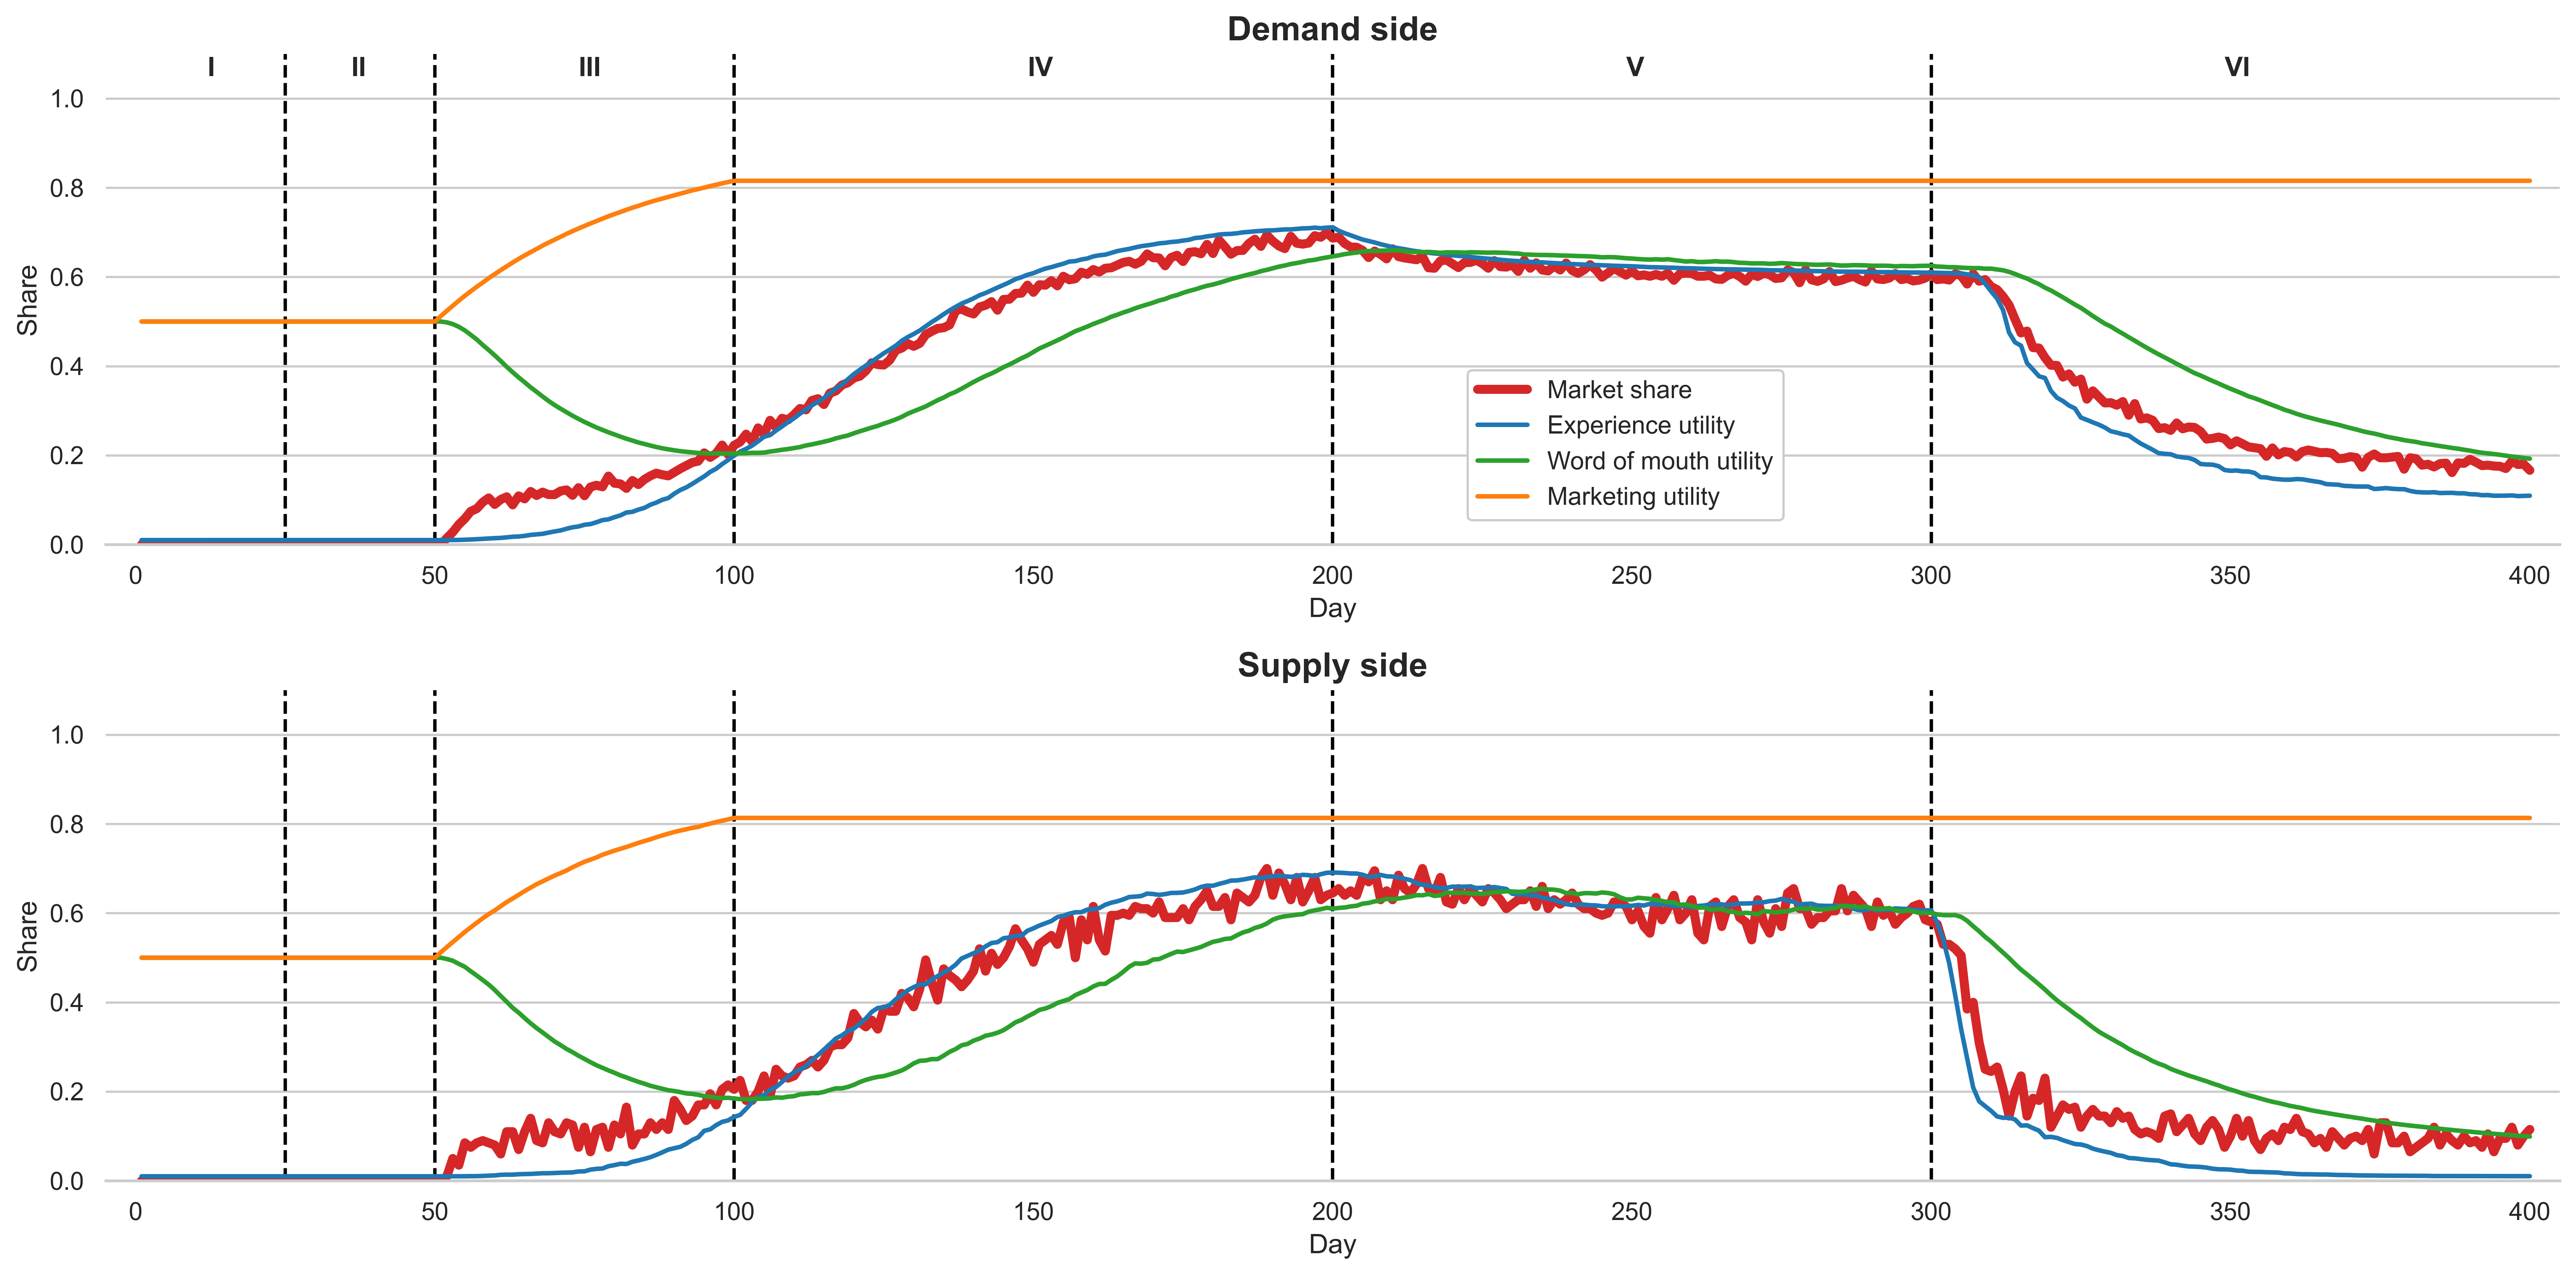

In [7]:
# with S-shaped curve nD=200 nP=2000 nV=200, with increased passenger sensitivity to changes in system
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

In [31]:
sim.platforms.comm_rate = 2
sim.platforms

fare  name  batch_time  base_fare  min_fare  comm_rate
1   1.2   NaN         NaN        1.4       2.0          2

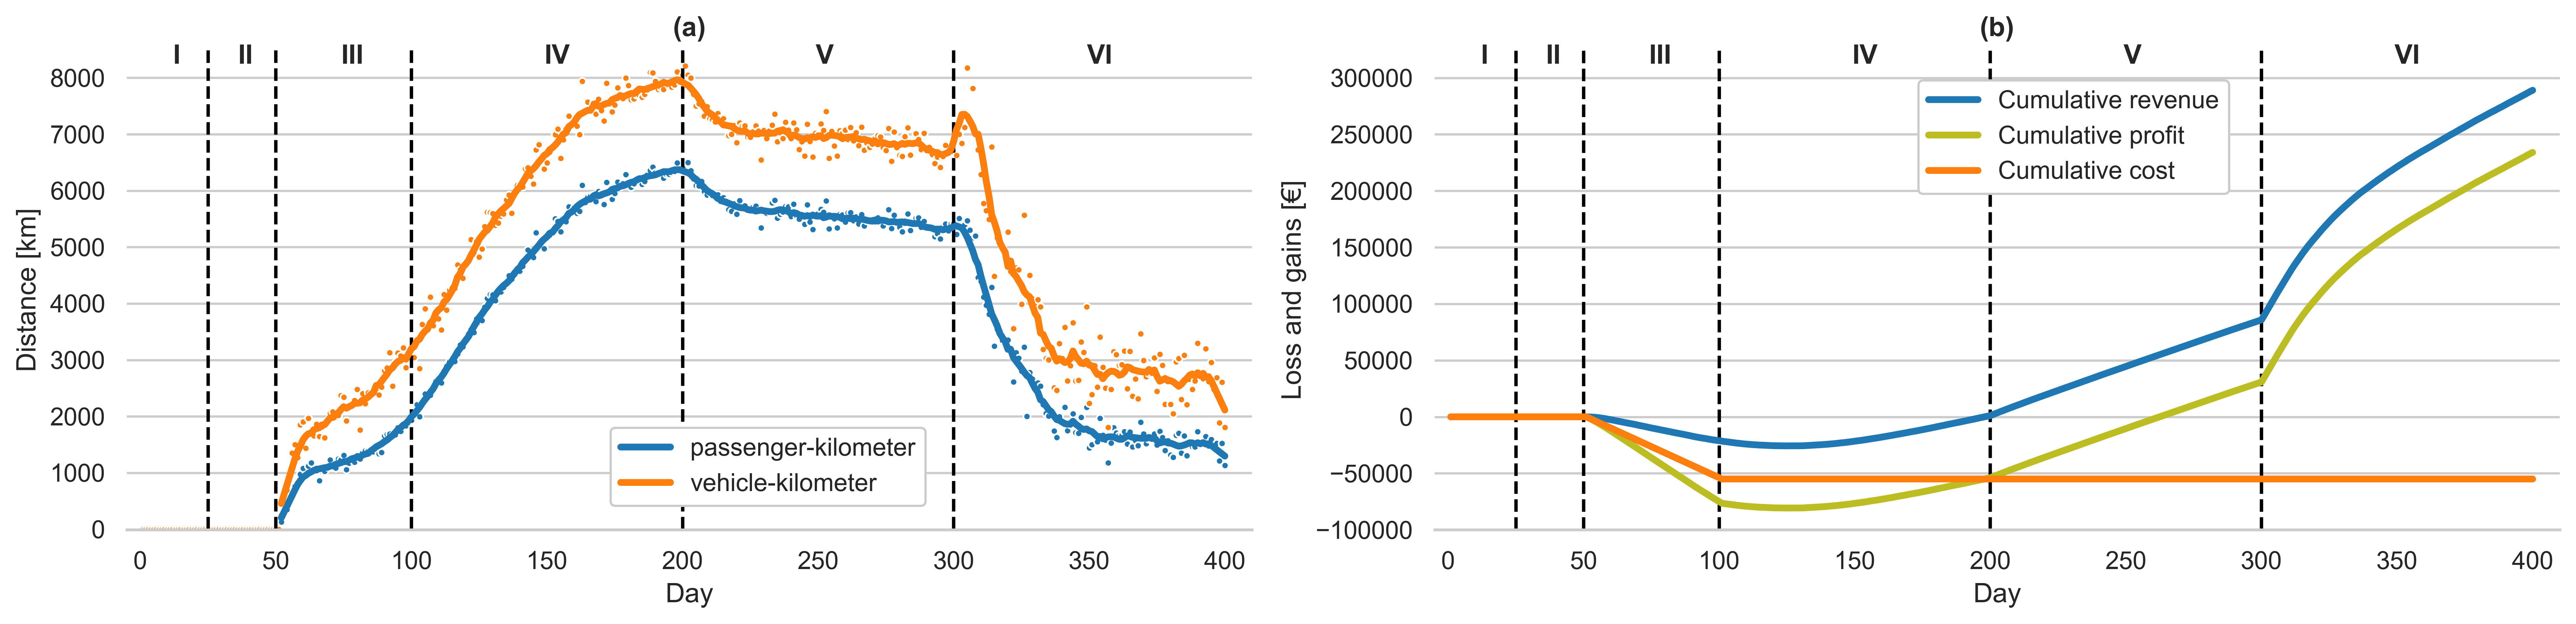

In [11]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(ncols=2,figsize=(16,4))
sns.despine(left=True)

x = []
ypkm = []
yvkm = []

for d in range(0,sim.params.nD):
    df = sim.res[d].veh_exp
    df['pkm'] = df.DRIVING_DIST-df.PICKUP_DIST
    ypkm.append(df.pkm.sum())
    yvkm.append(df.DRIVING_DIST.sum())

x = [i for i in range(1,len(ypkm)+1)]

ypkms = smooth(ypkm)
yvkms = smooth(yvkm)
sns.lineplot(x=x, y=ypkms, lw=3, label = 'passenger-kilometer', ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=yvkms, lw=3, label = 'vehicle-kilometer', color='C1', ax=ax[0])#, marker='o')
lines, labels = ax[0].get_legend_handles_labels()

sns.scatterplot(x=x, y=ypkm, s=10,label = 'passenger-kilometer',ax=ax[0])#, marker='o')
sns.scatterplot(x=x, y=yvkm, s=10,label = 'vehicle-kilometer', color='C1',ax=ax[0])#, marker='o')

ax[0].set(ylim=(-10,8500), xlim=(-5,410), xlabel='Day', ylabel='Distance [km]')
ax[0].legend(lines, labels ,framealpha=1, loc=(0.43,0.05))
ax[0].grid(axis='x')
ax[0].vlines([25, 50, 100, 200, 300], 0, 8500, linestyles='dashed', colors='black')

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,8250),(36,8250),(74,8250),(149,8250),(249,8250),(349,8250)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')
#-----------------------------------------------------------------------------------
x = []
ypr = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    ypr.append(df[df.OUT==False].plat_profit.sum())
x = [i for i in range(1,len(ypr)+1)]

df = pd.Series(ypr).to_frame()
df.columns = ['income']
marketing_costs = 0.5
df['marketing costs']=df.apply(lambda x: -marketing_costs*2200 if x.name >50 and x.name<=100 else 0, axis = 1).astype(int)
df['profit']=df.income + df['marketing costs']

sns.lineplot(x=x, y=df.income.cumsum(), lw=3, label = 'Cumulative revenue', color='C0',ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=df.profit.cumsum(), lw=3, label = 'Cumulative profit', color='C8',ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=df['marketing costs'].astype(int).cumsum(), lw=3, label = 'Cumulative cost', color='C1',ax=ax[1])#, marker='o')

ax[1].grid(axis='x')
ax[1].vlines([25, 50, 100, 200, 300], -100000, 325000, linestyles='dashed', colors='black')
# sns.lineplot(x=x, y=ypr, label = 'plat_profit')#, marker='o')
sns.despine(left=True)
ax[1].set(xlim=(-5,410), ylim=(-100000,325000), xlabel='Day', ylabel='Loss and gains [€]')
ax[1].legend(framealpha=1, loc=(0.43,0.7))

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,312500),(36,312500),(74,312500),(149,312500),(249,312500),(349,312500)]
    ax[1].annotate(value[i], xy =coords[i], fontweight='bold')
    

ax[0].set_title('(a)',fontweight='bold')
ax[1].set_title('(b)',fontweight='bold')


plt.tight_layout()
plt.savefig('Fig4.png')

<AxesSubplot:>

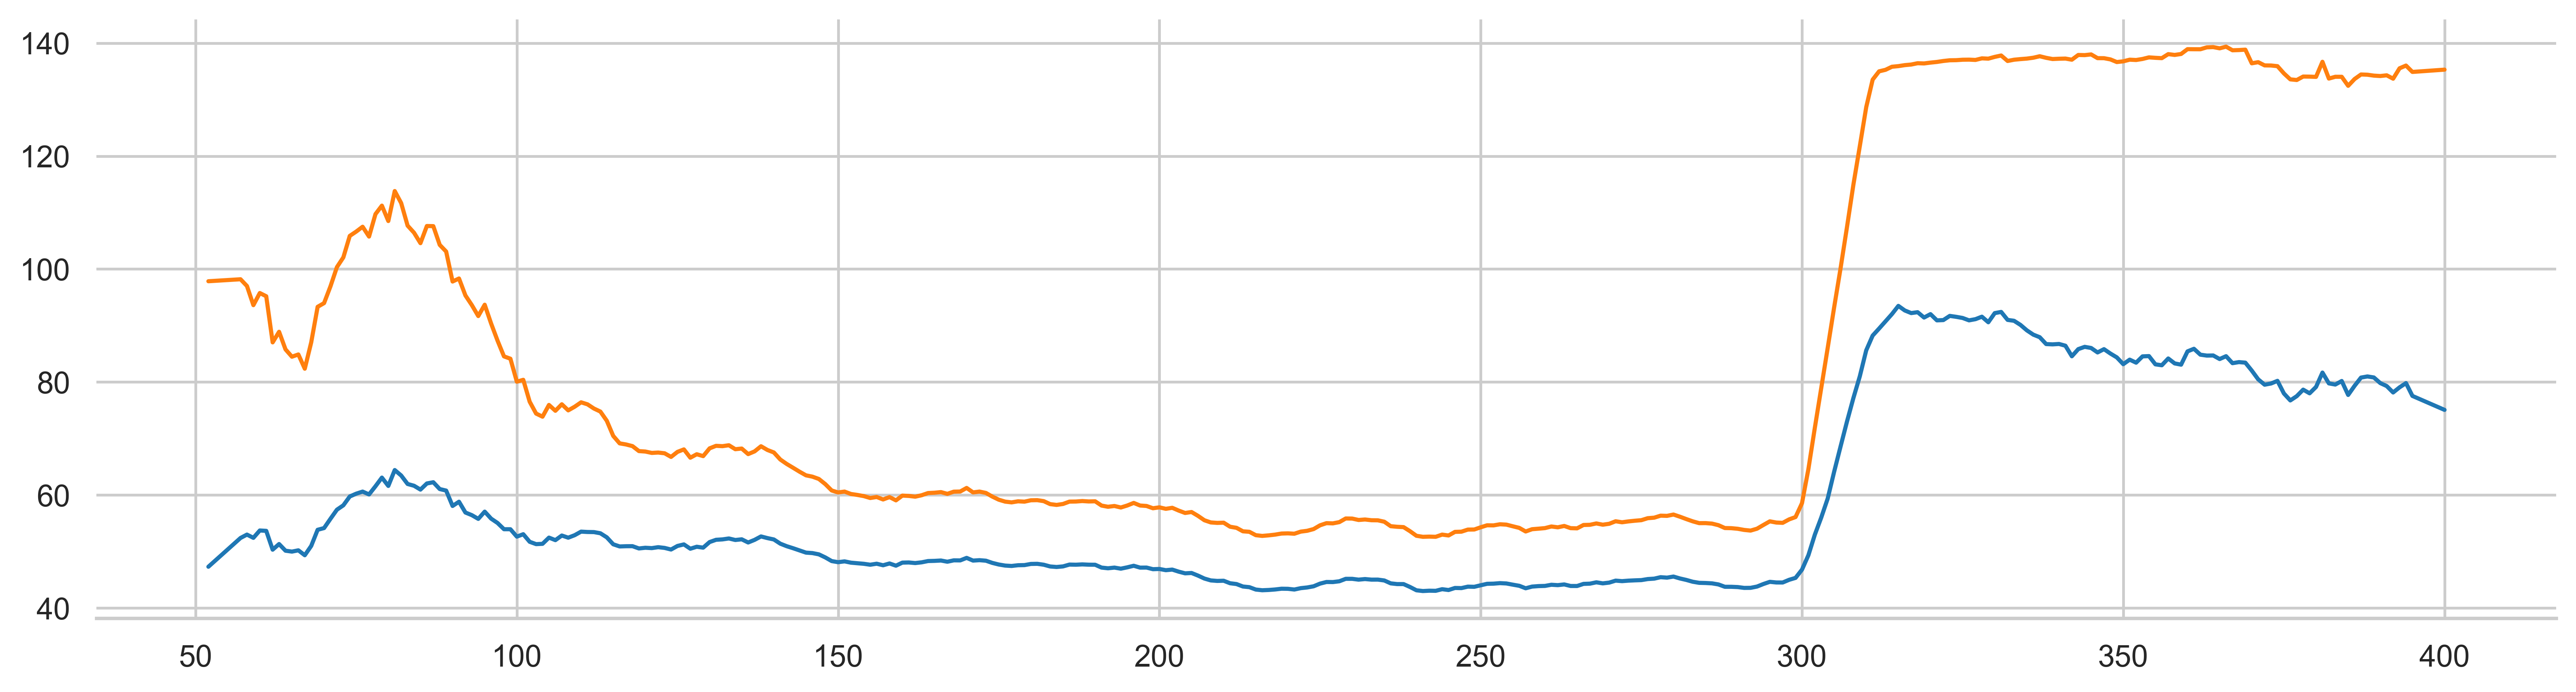

In [133]:
fig, ax = plt.subplots(figsize=(16,4))
sns.despine(left=True)

x = []
ypkm = []
yvkm = []

for d in range(0,sim.params.nD):
    df = sim.res[d].veh_exp
    df['pkm'] = df.DRIVING_DIST-df.PICKUP_DIST
    ypkm.append(df[df.OUT==False].pkm.mean())
    yvkm.append(df[df.OUT==False].DRIVING_DIST.mean())

x = [i for i in range(1,len(ypkm)+1)]

ypkms = smooth(ypkm)
yvkms = smooth(yvkm)

sns.lineplot(x=x, y=ypkms)
sns.lineplot(x=x, y=yvkms)

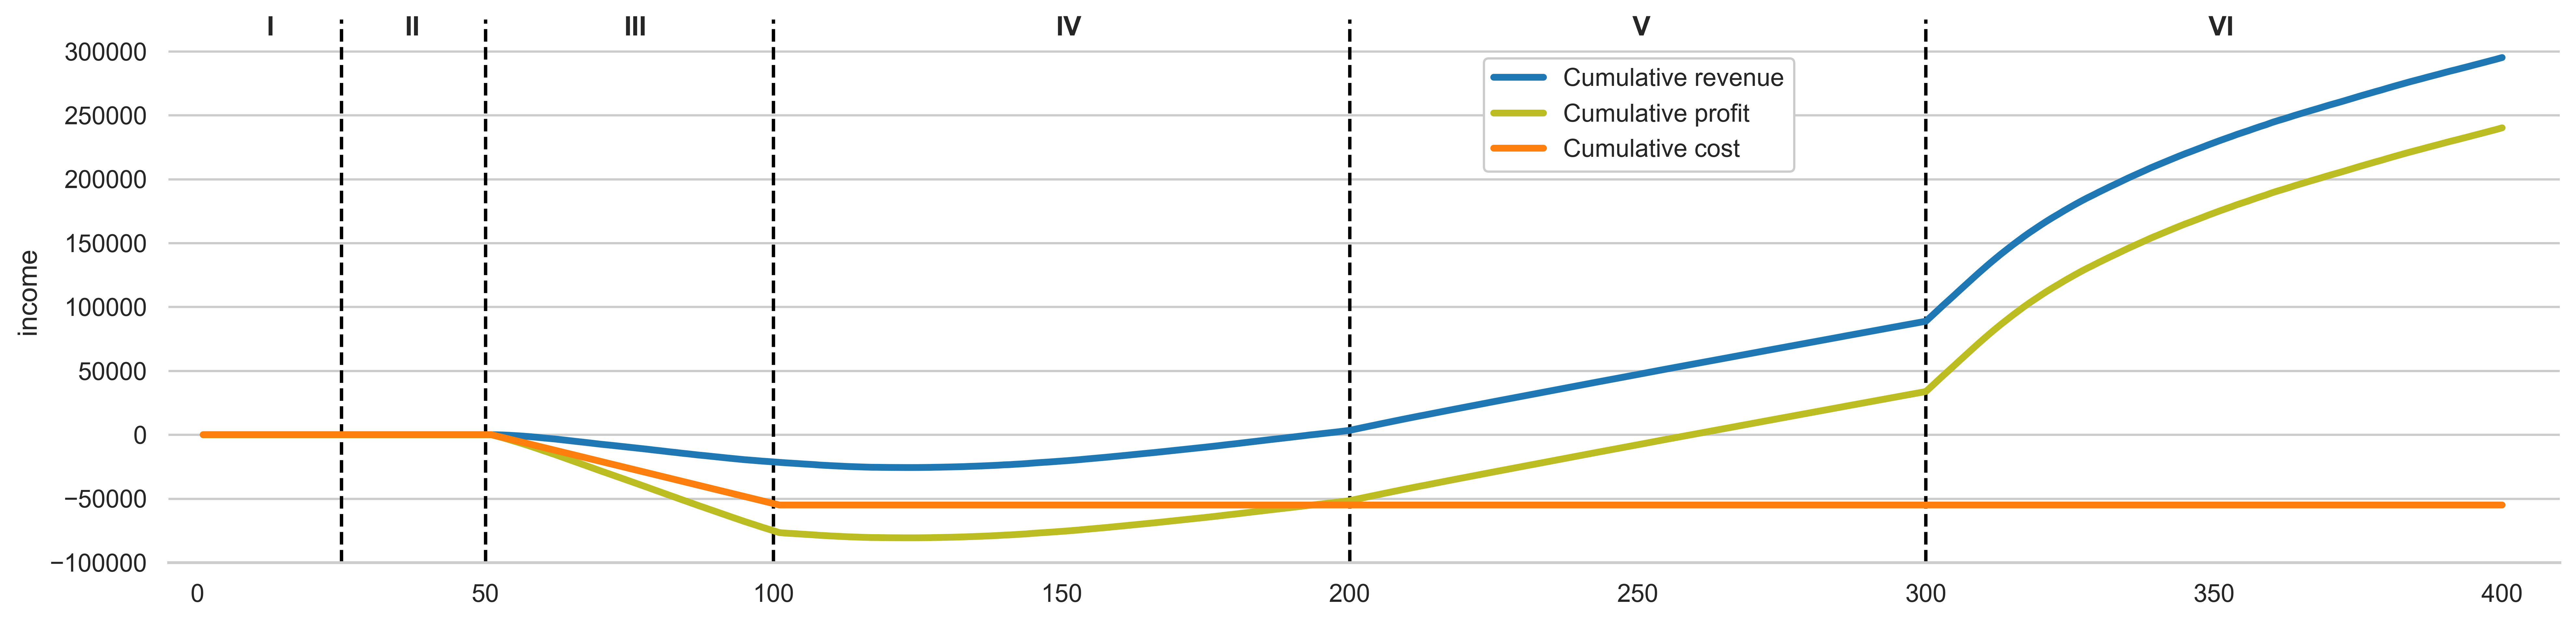

In [177]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,4))
sns.despine(left=True)

x = []
ypr = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    ypr.append(df[df.OUT==False].plat_profit.sum())
x = [i for i in range(1,len(ypr)+1)]

df = pd.Series(ypr).to_frame()
df.columns = ['income']
marketing_costs = 0.5
df['marketing costs']=df.apply(lambda x: -marketing_costs*2200 if x.name >50 and x.name<=100 else 0, axis = 1).astype(int)
df['profit']=df.income + df['marketing costs']

sns.lineplot(x=x, y=df.income.cumsum(), lw=3, label = 'Cumulative revenue', color='C0')#, marker='o')
sns.lineplot(x=x, y=df.profit.cumsum(), lw=3, label = 'Cumulative profit', color='C8')#, marker='o')
sns.lineplot(x=x, y=df['marketing costs'].astype(int).cumsum(), lw=3, label = 'Cumulative cost', color='C1')#, marker='o')

ax.grid(axis='x')
ax.vlines([25, 50, 100, 200, 300], -100000, 325000, linestyles='dashed', colors='black')
# sns.lineplot(x=x, y=ypr, label = 'plat_profit')#, marker='o')
sns.despine(left=True)
ax.set(xlim=(-5,410), ylim=(-100000,325000))
ax.legend(framealpha=1, loc=(0.55,0.72))

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,312500),(36,312500),(74,312500),(149,312500),(249,312500),(349,312500)]
    ax.annotate(value[i], xy =coords[i], fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig5.png')

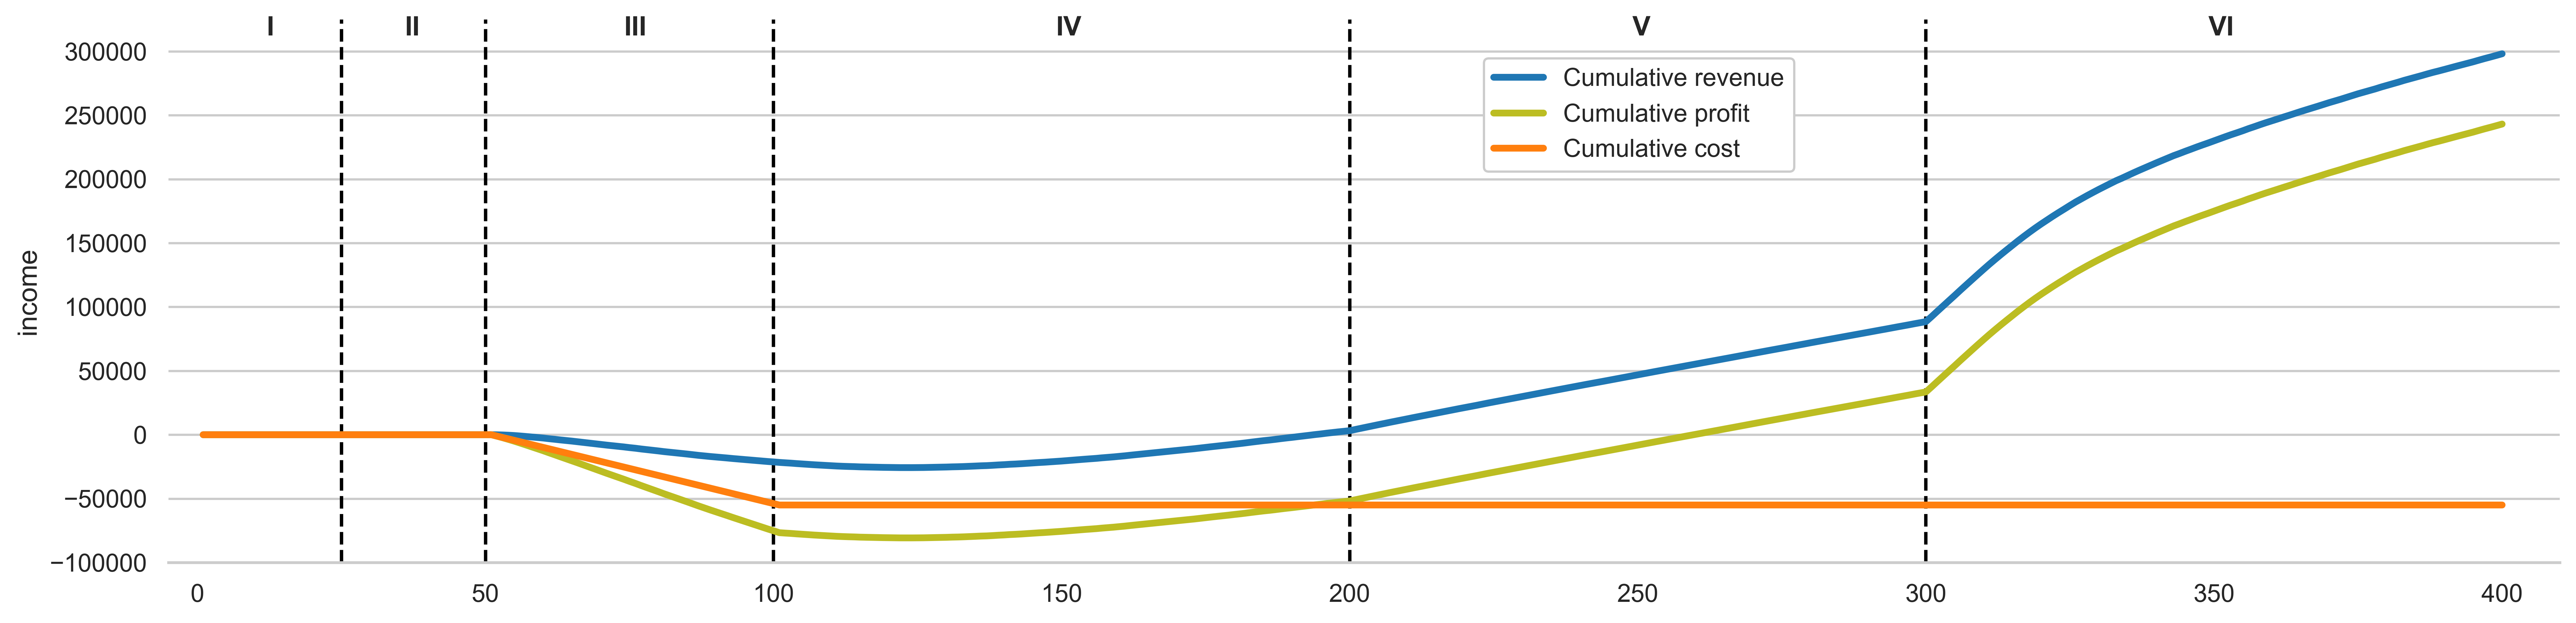

In [8]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,4))
sns.despine(left=True)

x = []
ypr = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    ypr.append(df[df.OUT==False].plat_profit.sum())
x = [i for i in range(1,len(ypr)+1)]

df = pd.Series(ypr).to_frame()
df.columns = ['income']
marketing_costs = 0.5
df['marketing costs']=df.apply(lambda x: -marketing_costs*2200 if x.name >50 and x.name<=100 else 0, axis = 1).astype(int)
df['profit']=df.income + df['marketing costs']

sns.lineplot(x=x, y=df.income.cumsum(), lw=3, label = 'Cumulative revenue', color='C0')#, marker='o')
sns.lineplot(x=x, y=df.profit.cumsum(), lw=3, label = 'Cumulative profit', color='C8')#, marker='o')
sns.lineplot(x=x, y=df['marketing costs'].astype(int).cumsum(), lw=3, label = 'Cumulative cost', color='C1')#, marker='o')

ax.grid(axis='x')
ax.vlines([25, 50, 100, 200, 300], -100000, 325000, linestyles='dashed', colors='black')
# sns.lineplot(x=x, y=ypr, label = 'plat_profit')#, marker='o')
sns.despine(left=True)
ax.set(xlim=(-5,410), ylim=(-100000,325000))
ax.legend(framealpha=1, loc=(0.55,0.72))

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,312500),(36,312500),(74,312500),(149,312500),(249,312500),(349,312500)]
    ax.annotate(value[i], xy =coords[i], fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig5.png')

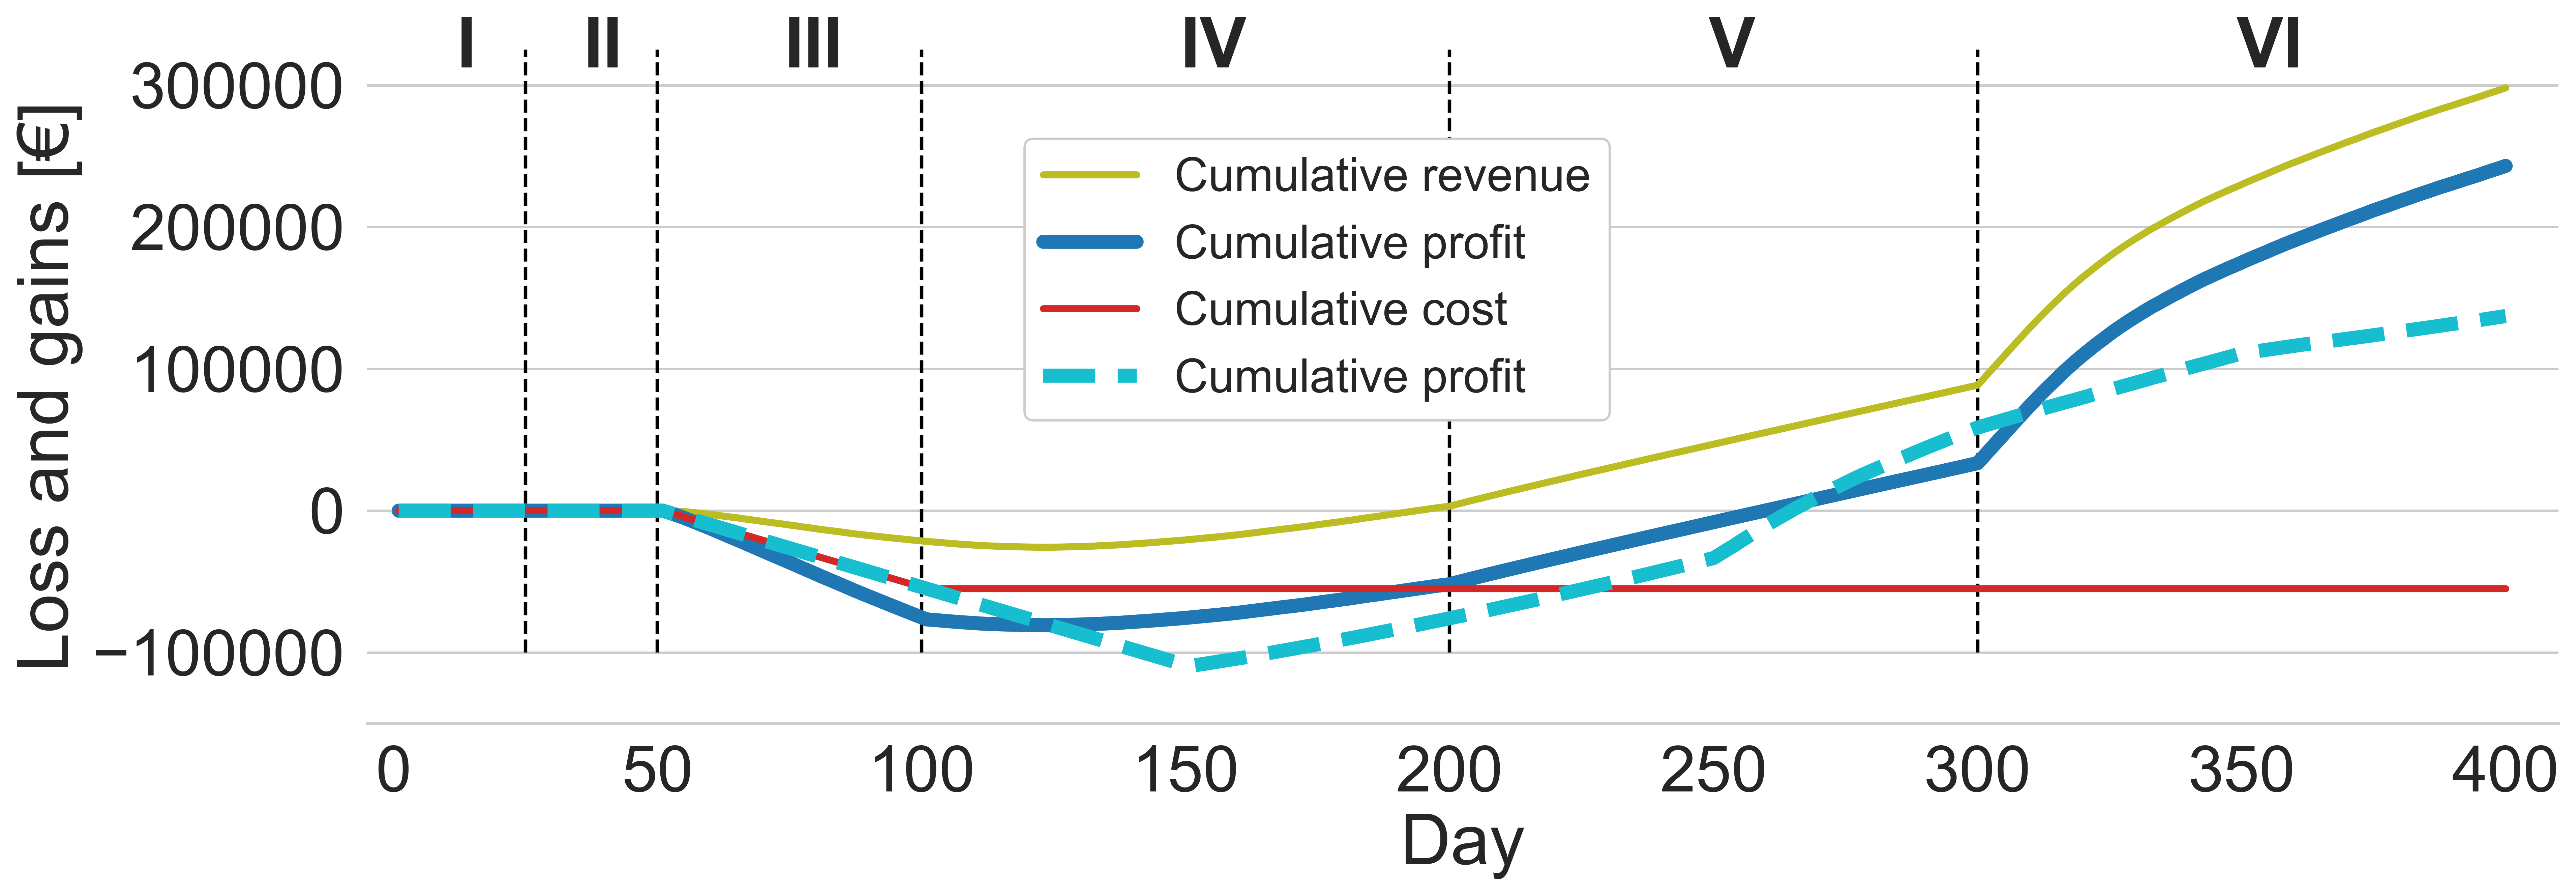

In [19]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=2.5)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,6))
sns.despine(left=True)

x = []
ypr = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    ypr.append(df[df.OUT==False].plat_profit.sum())
x = [i for i in range(1,len(ypr)+1)]

df = pd.Series(ypr).to_frame()
df.columns = ['income']
marketing_costs = 0.5
df['marketing costs']=df.apply(lambda x: -marketing_costs*2200 if x.name >50 and x.name<=100 else 0, axis = 1).astype(int)
df['profit']=df.income + df['marketing costs']

sns.lineplot(x=x, y=df.income.cumsum(), lw=3, label = 'Cumulative revenue', color='C8')#, marker='o')
sns.lineplot(x=x, y=df.profit.cumsum(), lw=6, label = 'Cumulative profit', color='C0')#, marker='o')
sns.lineplot(x=x, y=df['marketing costs'].astype(int).cumsum(), lw=3, label = 'Cumulative cost', color='C3')#, marker='o')
sns.lineplot(x=x, y=z, lw=6, label = 'Cumulative profit', color='C9')#, marker='o')
ax.lines[3].set_linestyle("--")

ax.grid(axis='x')
ax.vlines([25, 50, 100, 200, 300], -100000, 325000, linestyles='dashed', colors='black')
# sns.lineplot(x=x, y=ypr, label = 'plat_profit')#, marker='o')
sns.despine(left=True)
ax.set(xlim=(-5,410), ylim=(-150000,325000))
ax.legend(framealpha=1, loc=(0.3,0.45), fontsize=20)
ax.set(xlabel='Day', ylabel='Loss and gains [€]')

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,312500),(36,312500),(74,312500),(149,312500),(249,312500),(349,312500)]
    ax.annotate(value[i], xy =coords[i], fontweight='bold')

plt.tight_layout()
plt.savefig('Fig_aamas_last.png')

In [20]:
df.profit.cumsum()

0           0.00000
1           0.00000
2           0.00000
3           0.00000
4           0.00000
           ...     
395    238134.13252
396    239398.52252
397    240588.87372
398    241813.55372
399    243096.30552
Name: profit, Length: 400, dtype: float64

In [22]:
(243096.30552-137201.28576)/137201.28576

0.771822357009375

In [25]:
ff = pd.DataFrame()


ff['days'] = [i for i in range(0, 400)]
ff['profit'] = df.profit.cumsum()
ff['profit_alt'] = z
ff['revenue'] = y=df.income.cumsum()
ff['cost'] = df['marketing costs'].astype(int).cumsum()

ff.to_csv('last_fig.csv')
ff

days        profit    profit_alt       revenue   cost
0       0       0.00000       0.00000       0.00000      0
1       1       0.00000       0.00000       0.00000      0
2       2       0.00000       0.00000       0.00000      0
3       3       0.00000       0.00000       0.00000      0
4       4       0.00000       0.00000       0.00000      0
..    ...           ...           ...           ...    ...
395   395  238134.13252  134927.17448  293134.13252 -55000
396   396  239398.52252  135522.59848  294398.52252 -55000
397   397  240588.87372  136082.38696  295588.87372 -55000
398   398  241813.55372  136675.25944  296813.55372 -55000
399   399  243096.30552  137201.28576  298096.30552 -55000

[400 rows x 5 columns]

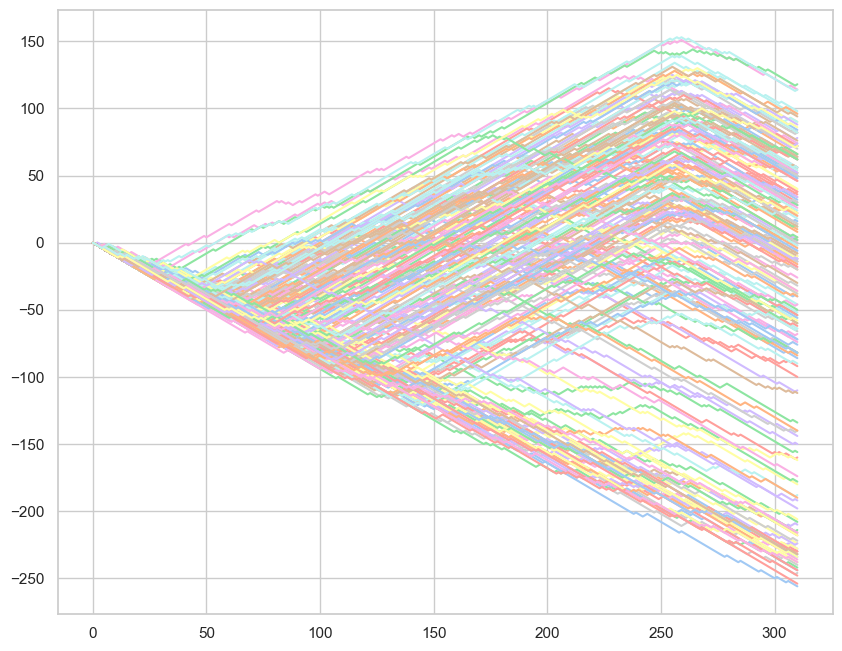

In [639]:
fig, ax = plt.subplots(figsize=(10,8))
for veh in range(1,sim.params.nV+1):
    ly = [0]
    for run_id in range(50, len(sim.res)):
        if sim.res[run_id].veh_exp.loc[veh].mu==0: ly.append(ly[-1]-1)
        else: ly.append(ly[-1]+1)
    lx = [i for i in range(0,len(ly),1)]
    sns.lineplot(x=lx, y=ly)
#ax.legend("drivers'working status")

In [7]:
df = pd.read_csv('last_fig.csv')
df

Unnamed: 0  days        profit    profit_alt       revenue   cost
0             0     0       0.00000       0.00000       0.00000      0
1             1     1       0.00000       0.00000       0.00000      0
2             2     2       0.00000       0.00000       0.00000      0
3             3     3       0.00000       0.00000       0.00000      0
4             4     4       0.00000       0.00000       0.00000      0
..          ...   ...           ...           ...           ...    ...
395         395   395  238134.13252  134927.17448  293134.13252 -55000
396         396   396  239398.52252  135522.59848  294398.52252 -55000
397         397   397  240588.87372  136082.38696  295588.87372 -55000
398         398   398  241813.55372  136675.25944  296813.55372 -55000
399         399   399  243096.30552  137201.28576  298096.30552 -55000

[400 rows x 6 columns]

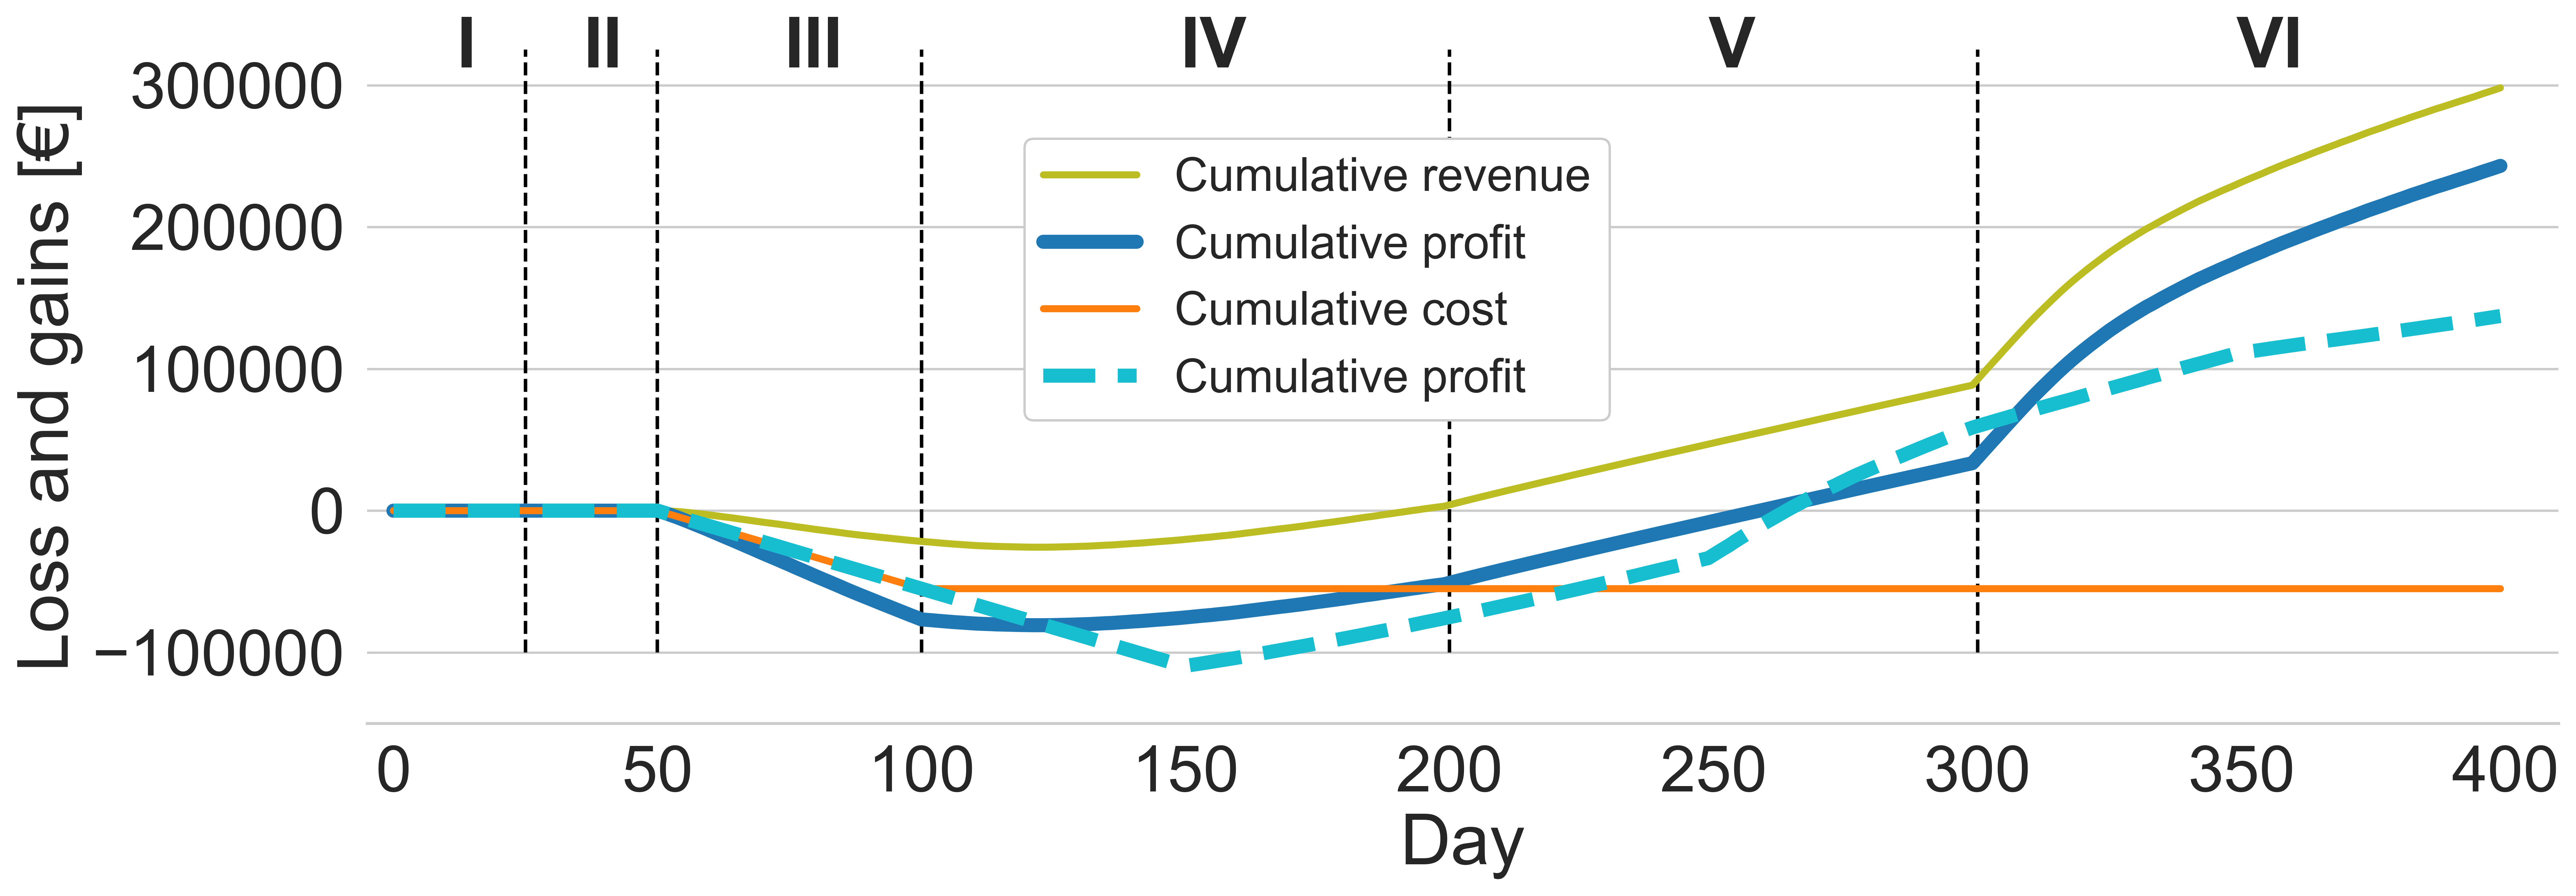

In [10]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=2.5)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,6))
sns.despine(left=True)


sns.lineplot(x=df['days'], y=df['revenue'], lw=3, label = 'Cumulative revenue', color='C8')#, marker='o')
sns.lineplot(x=df['days'], y=df['profit'], lw=6, label = 'Cumulative profit', color='C0')#, marker='o')
sns.lineplot(x=df['days'], y=df['cost'], lw=3, label = 'Cumulative cost', color='C1')#, marker='o')
sns.lineplot(x=df['days'], y=df['profit_alt'], lw=6, label = 'Cumulative profit', color='C9')#, marker='o')
ax.lines[3].set_linestyle("--")

ax.grid(axis='x')
ax.vlines([25, 50, 100, 200, 300], -100000, 325000, linestyles='dashed', colors='black')
# sns.lineplot(x=x, y=ypr, label = 'plat_profit')#, marker='o')
sns.despine(left=True)
ax.set(xlim=(-5,410), ylim=(-150000,325000))
ax.legend(framealpha=1, loc=(0.3,0.45), fontsize=20)
ax.set(xlabel='Day', ylabel='Loss and gains [€]')

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,312500),(36,312500),(74,312500),(149,312500),(249,312500),(349,312500)]
    ax.annotate(value[i], xy =coords[i], fontweight='bold')

plt.tight_layout()
plt.savefig('Fig_aamas_last.png')